In [3]:
!pip install tqdm
!pip install keras
!rm -f drive/app/NASA*
!wget ftp://ita.ee.lbl.gov/traces/NASA_access_log_Jul95.gz -P drive/app
!gunzip drive/app/NASA_access_log_Jul95.gz
!wget ftp://ita.ee.lbl.gov/traces/NASA_access_log_Aug95.gz -P drive/app
!gunzip drive/app/NASA_access_log_Aug95.gz
!mv drive/app/NASA_access_log_Jul95 drive/app/NASA.log
!cat drive/app/NASA_access_log_Aug95 >> drive/app/NASA.log
!head drive/app/NASA.log
!wc -l drive/app/NASA.log

    100% |████████████████████████████████| 51kB 2.9MB/s 
--2018-05-20 16:15:58--  ftp://ita.ee.lbl.gov/traces/NASA_access_log_Jul95.gz
           => ‘drive/app/NASA_access_log_Jul95.gz’
Resolving ita.ee.lbl.gov (ita.ee.lbl.gov)... 131.243.2.164, 2620:83:8000:102::a4
Connecting to ita.ee.lbl.gov (ita.ee.lbl.gov)|131.243.2.164|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /traces ... done.
==> SIZE NASA_access_log_Jul95.gz ... 20676672
==> PASV ... done.    ==> RETR NASA_access_log_Jul95.gz ... done.
Length: 20676672 (20M) (unauthoritative)

NASA_access_log_Jul 100%[===================>]  19.72M  2.91MB/s    in 6.8s    

2018-05-20 16:16:06 (2.90 MB/s) - ‘drive/app/NASA_access_log_Jul95.gz’ saved [20676672]

--2018-05-20 16:16:09--  ftp://ita.ee.lbl.gov/traces/NASA_access_log_Aug95.gz
           => ‘drive/app/NASA_access_log_Aug95.gz’
Resolving ita.ee.lbl.gov (ita.ee.lbl.gov)... 131.243.2.164, 2620:83:8

NASA_access_log_Aug 100%[===================>]  15.86M  2.91MB/s    in 5.5s    

2018-05-20 16:16:15 (2.89 MB/s) - ‘drive/app/NASA_access_log_Aug95.gz’ saved [16633316]

199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245
unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985
199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085
burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0
199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179
burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0
burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0
205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTT

In [4]:
import string
import datetime

import numpy as np
import matplotlib.pyplot as plt

from time import time
from tqdm import tqdm
from functools import reduce
from collections import Counter

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from google.colab import files


from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [0]:
# Parameters
DATASET = "drive/app/NASA.log"
WINDOW_SIZE = 3
NB_HIDDEN_LAYERS = 100

In [0]:
def load_dataset():
    dataset = []
    with open(DATASET, 'r', encoding='utf-8', errors='ignore') as f:
      for line in tqdm(f):
        dataset.append("".join(l for l in line.replace("\n", "") if l in string.printable))

    print(len(dataset))    
    return dataset

In [0]:
def parse_line(line):
    d = datetime.datetime.strptime(line.split(' ')[3][1:], "%d/%b/%Y:%H:%M:%S")
    bytes_in_reply = line.split(' ')[-1]
    bytes_in_reply = 0 if bytes_in_reply == '-' else int(bytes_in_reply)
          
    return (d.toordinal(), d.time().hour, d.weekday(), d.month, bytes_in_reply)

In [0]:
def parse_dataset(dataset):
    parsed_lines = []
    for i, line in tqdm(enumerate(dataset)):
        parsed_lines.append(parse_line(line))

    return parsed_lines


In [0]:
def build_metadata(max_values, min_values):
    metadata = {'window_size': WINDOW_SIZE, 'min_values': min_values, 'max_values': max_values}

    with open(args.output + '.metadata.bin', 'wb') as f:
        pk.dump(metadata, f)


In [0]:
# This function is not written in a pythonic way to better handle massive amount of data
def build_data(parsed_dataset):
    data = []
    count = 0
    data_amount = 0
    previous_sample = parsed_dataset[0]
    for i in tqdm(range(1, len(parsed_dataset))):
        if parsed_dataset[i][:3] == previous_sample[:3]:
            data_amount += previous_sample[4]
            count += 1
        else:
            data.append(np.array((count, previous_sample[1], data_amount), dtype=np.float32))
            previous_sample = parsed_dataset[i]
            data_amount = previous_sample[4]
            count = 1
      
    # Scale all features btw 0 and 1
    scale = MinMaxScaler(feature_range=(0, 1))
    n_data = scale.fit_transform(data)
    data_max = scale.data_max_
    data_min = scale.data_min_
    
    X = []
    for i in range(0, len(n_data) - WINDOW_SIZE):
        X.append(np.array(n_data[i:i+WINDOW_SIZE]))
    
    y = []
    for i in range(0, len(n_data) - WINDOW_SIZE):
        y.append(n_data[i+WINDOW_SIZE])
    
      
    return X, y, data, scale

In [0]:
# Here, either we take the first ratio*100 percent or the last to get the testing data (because ordering matters!)
def split_data(X, y, ratio=0.20):
    after = np.random.randint(0,2)
    cut = round(len(X) - ratio * len(X)) if after else round(ratio * len(X)) 
    
    X_test = np.array(X[cut:]) if after else np.array(X[:cut])
    y_test = np.array(y[cut:])[:, :1] if after else np.array(y[:cut])[:, :1]
      
    X_train = np.array(X[:cut]) if after else np.array(X[cut:])
    y_train = np.array(y[:cut])[:, :1] if after else np.array(y[cut:])[:, :1]
    
    print("Number of training samples: {}".format(len(X_train)))
    print("Number of testing samples: {}".format(len(X_test)))
    
    return X_train, y_train, X_test, y_test
    

In [0]:
def display_info(data):
  hours = np.arange(24)
  x_hours = hours
  for i in range(1, round(len(data) / 24)):
    x_hours = np.concatenate([x_hours, hours])
  
  y_sums = np.array([x[0] for x in data[:24]]) 
  for i in range(24, len(data), 24):
    y_sums += np.array([x[0] for x in data[i:i+24]])
  
  y_means = y_sums / (len(data) / 24)
  
  y_stds = np.array([np.power(y[0] - y_means[i], 2) for i, y in enumerate(data[:24])])
  for i in range(24, len(data), 24):
    y_stds += np.array([np.power(y[0] - y_means[j % 24], 2) for j, y in enumerate(data[i:i+24])])
  
  y_stds = np.sqrt(y_stds / y_sums)
   
  y_stds = y_stds.astype(int)
  y_means = y_means.astype(int)  
    
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(50, 10))
  ax1.scatter(x=x_hours, y=[x[0] for x in data], marker='o', c='r', edgecolor='b', s=2)
  ax1.set_xlabel('Hour', fontsize=20)
  ax1.set_ylabel('Request hits number', fontsize=20)
 
  ax2.errorbar(np.arange(24), y_means, yerr=2*y_stds, fmt='o', ecolor='r', capthick=2)
  #ax2.scatter(x=x_hours, y=[x[0] for x in data], marker='o', c='r', edgecolor='b', s=2)
  ax2.set_xlabel('Hour', fontsize=20)
  ax2.set_ylabel('Mean and standard deviation error', fontsize=20)
  
  ax3.plot([x[0] for x in data], c='r')
  ax3.set_xlabel('Hour', fontsize=20)
  ax3.set_ylabel('Request hits number', fontsize=20)
                                 
  ax4.plot([x[2] for x in data], c='b')
  ax4.set_xlabel('Hour', fontsize=20)
  ax4.set_ylabel('Data amount', fontsize=20)                               
  
 
  
  

In [0]:
def train(X_train, y_train, X_test, Y_test):
    model = Sequential()
    model.add(LSTM(NB_HIDDEN_LAYERS, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=False)
    
    return model

In [0]:
def compare_plot(model, scale, X_test, y_test):
  results = model.predict(X_test, batch_size=32) 

  min_scale = scale.data_max_[0]
  max_scale = scale.data_max_[1]
  
  y_test_for_plot = y_test * (max_scale - min_scale) + min_scale
  results_for_plot = results * (max_scale - min_scale) + min_scale
  
  y_diff = y_test_for_plot - results_for_plot
  
  y_diff_mean = np.mean(y_diff)
  y_diff_std = np.std(y_diff)
  
  print("Mean: {}, Std: {}".format(y_diff_mean, y_diff_std))
    
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
  ax1.plot([y[0] for y in y_test_for_plot], c='g')
  ax1.plot([r[0] for r in results_for_plot], c='b')
  ax1.set_xlabel('Hour', fontsize=20)
  ax1.set_ylabel('Request hits number (green = ground truth)', fontsize=20)
 
  ax2.plot([y[0] for y in y_diff], c='r')
  ax2.set_ylim([-2000, 15000])
  ax2.set_xlabel('Hour', fontsize=20)
  ax2.set_ylabel('Difference ground truth minus prediction', fontsize=20)
  
  plt.show()
      

In [15]:
dataset = load_dataset()


3461612it [01:07, 50927.32it/s]

3461612


In [16]:
start = time()
parsed_dataset = parse_dataset(dataset)
print("{} seconds spent on parsing data".format(time() - start))

3461612it [01:03, 54625.61it/s]

63.37588453292847 seconds spent on parsing data


In [91]:
start = time()
X, y, data, scale = build_data(parsed_dataset)
print("{} seconds spent on building data".format(time() - start))


100%|██████████| 3461611/3461611 [00:02<00:00, 1515382.60it/s]

2.295596122741699 seconds spent on building data


In [92]:
start = time()
X_train, y_train, X_test, y_test = split_data(X, y)
print("{} seconds spent on splitting data".format(time() - start))

Number of training samples: 1092
Number of testing samples: 273
0.009499549865722656 seconds spent on splitting data


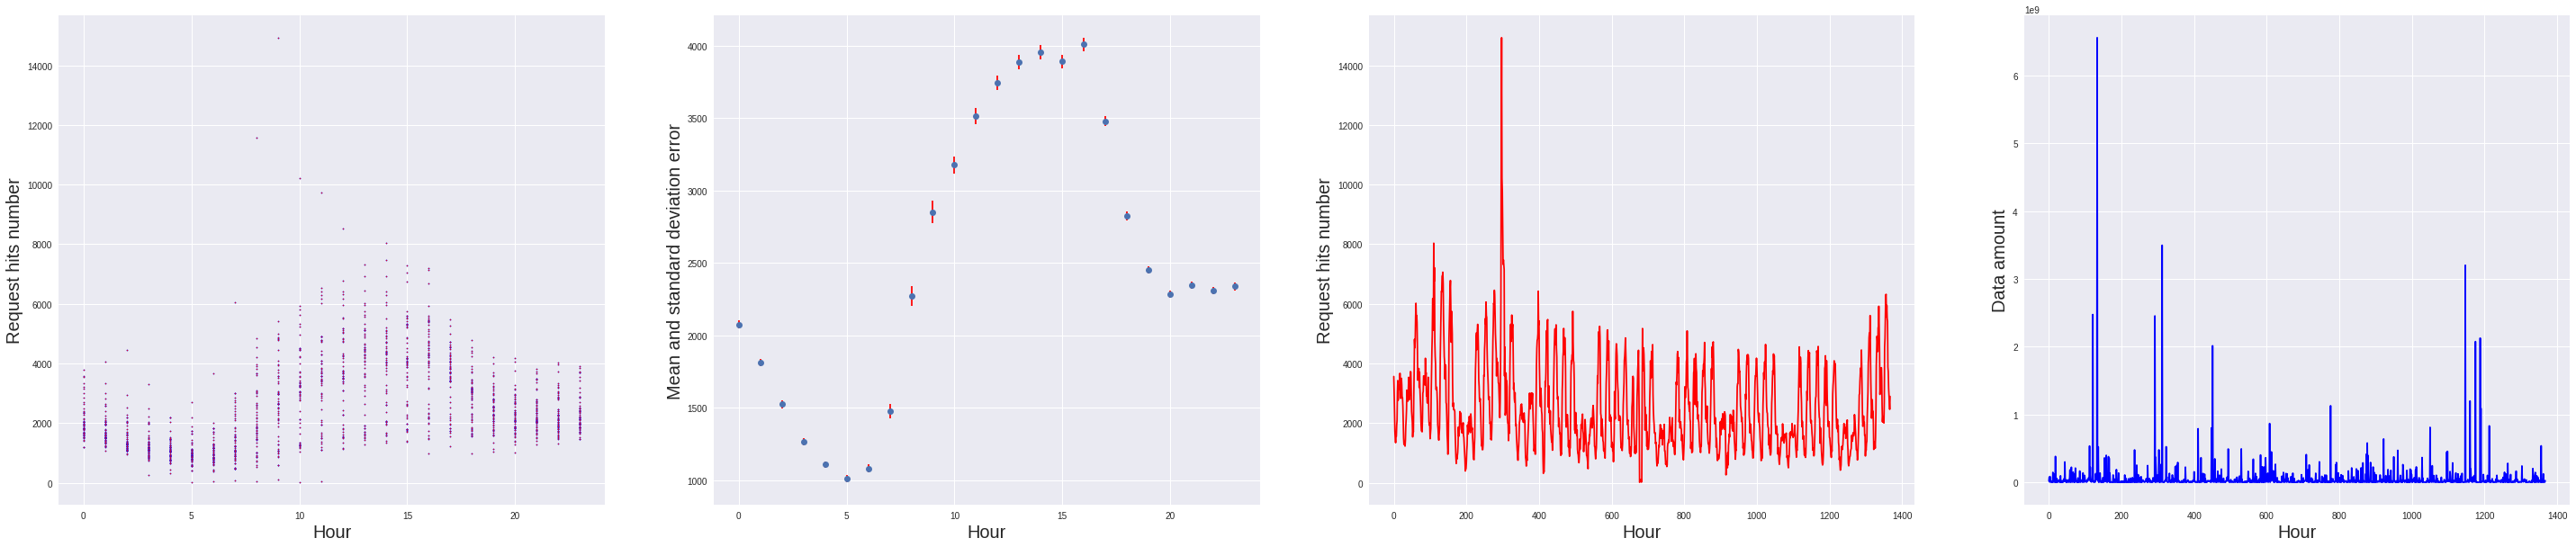

In [93]:
 display_info(data)

In [22]:
model = train(X_train, y_train, X_test, y_test)

Train on 1092 samples, validate on 273 samples
Epoch 1/500
 - 1s - loss: 0.0811 - val_loss: 0.0592
Epoch 2/500
 - 0s - loss: 0.0610 - val_loss: 0.0456
Epoch 3/500
 - 0s - loss: 0.0472 - val_loss: 0.0395
Epoch 4/500
 - 0s - loss: 0.0409 - val_loss: 0.0362
Epoch 5/500
 - 0s - loss: 0.0395 - val_loss: 0.0349
Epoch 6/500
 - 0s - loss: 0.0383 - val_loss: 0.0343
Epoch 7/500
 - 0s - loss: 0.0375 - val_loss: 0.0334
Epoch 8/500
 - 0s - loss: 0.0361 - val_loss: 0.0322
Epoch 9/500
 - 0s - loss: 0.0355 - val_loss: 0.0315
Epoch 10/500
 - 0s - loss: 0.0341 - val_loss: 0.0303
Epoch 11/500
 - 0s - loss: 0.0330 - val_loss: 0.0294
Epoch 12/500
 - 0s - loss: 0.0316 - val_loss: 0.0302
Epoch 13/500
 - 0s - loss: 0.0312 - val_loss: 0.0306
Epoch 14/500
 - 0s - loss: 0.0304 - val_loss: 0.0283
Epoch 15/500
 - 0s - loss: 0.0292 - val_loss: 0.0265
Epoch 16/500
 - 0s - loss: 0.0279 - val_loss: 0.0283
Epoch 17/500
 - 0s - loss: 0.0282 - val_loss: 0.0247
Epoch 18/500
 - 0s - loss: 0.0265 - val_loss: 0.0240
Epoch 19

 - 0s - loss: 0.0258 - val_loss: 0.0222
Epoch 44/500
 - 0s - loss: 0.0264 - val_loss: 0.0214
Epoch 45/500
 - 0s - loss: 0.0257 - val_loss: 0.0216
Epoch 46/500
 - 0s - loss: 0.0254 - val_loss: 0.0212
Epoch 47/500
 - 0s - loss: 0.0251 - val_loss: 0.0213
Epoch 48/500
 - 0s - loss: 0.0253 - val_loss: 0.0212
Epoch 49/500
 - 0s - loss: 0.0255 - val_loss: 0.0210
Epoch 50/500
 - 0s - loss: 0.0251 - val_loss: 0.0209
Epoch 51/500
 - 0s - loss: 0.0249 - val_loss: 0.0209
Epoch 52/500
 - 0s - loss: 0.0249 - val_loss: 0.0208
Epoch 53/500
 - 0s - loss: 0.0249 - val_loss: 0.0209
Epoch 54/500
 - 0s - loss: 0.0246 - val_loss: 0.0208
Epoch 55/500
 - 0s - loss: 0.0246 - val_loss: 0.0209
Epoch 56/500
 - 0s - loss: 0.0245 - val_loss: 0.0208
Epoch 57/500
 - 0s - loss: 0.0247 - val_loss: 0.0208
Epoch 58/500
 - 0s - loss: 0.0249 - val_loss: 0.0209
Epoch 59/500
 - 0s - loss: 0.0246 - val_loss: 0.0207
Epoch 60/500
 - 0s - loss: 0.0246 - val_loss: 0.0207
Epoch 61/500
 - 0s - loss: 0.0247 - val_loss: 0.0208
Epoch 

 - 0s - loss: 0.0240 - val_loss: 0.0203
Epoch 87/500
 - 0s - loss: 0.0242 - val_loss: 0.0205
Epoch 88/500
 - 0s - loss: 0.0242 - val_loss: 0.0202
Epoch 89/500
 - 0s - loss: 0.0242 - val_loss: 0.0203
Epoch 90/500
 - 0s - loss: 0.0243 - val_loss: 0.0204
Epoch 91/500
 - 0s - loss: 0.0241 - val_loss: 0.0203
Epoch 92/500
 - 0s - loss: 0.0240 - val_loss: 0.0205
Epoch 93/500
 - 0s - loss: 0.0241 - val_loss: 0.0202
Epoch 94/500
 - 0s - loss: 0.0242 - val_loss: 0.0203
Epoch 95/500
 - 0s - loss: 0.0242 - val_loss: 0.0206
Epoch 96/500
 - 0s - loss: 0.0239 - val_loss: 0.0204
Epoch 97/500
 - 0s - loss: 0.0236 - val_loss: 0.0203
Epoch 98/500
 - 1s - loss: 0.0239 - val_loss: 0.0204
Epoch 99/500
 - 0s - loss: 0.0237 - val_loss: 0.0202
Epoch 100/500
 - 0s - loss: 0.0237 - val_loss: 0.0202
Epoch 101/500
 - 0s - loss: 0.0237 - val_loss: 0.0201
Epoch 102/500
 - 0s - loss: 0.0237 - val_loss: 0.0201
Epoch 103/500
 - 0s - loss: 0.0237 - val_loss: 0.0202
Epoch 104/500
 - 0s - loss: 0.0237 - val_loss: 0.0202
E

Epoch 129/500
 - 0s - loss: 0.0233 - val_loss: 0.0198
Epoch 130/500
 - 0s - loss: 0.0239 - val_loss: 0.0200
Epoch 131/500
 - 0s - loss: 0.0235 - val_loss: 0.0201
Epoch 132/500
 - 0s - loss: 0.0229 - val_loss: 0.0197
Epoch 133/500
 - 0s - loss: 0.0235 - val_loss: 0.0200
Epoch 134/500
 - 0s - loss: 0.0234 - val_loss: 0.0199
Epoch 135/500
 - 0s - loss: 0.0235 - val_loss: 0.0199
Epoch 136/500
 - 0s - loss: 0.0230 - val_loss: 0.0197
Epoch 137/500
 - 0s - loss: 0.0232 - val_loss: 0.0198
Epoch 138/500
 - 0s - loss: 0.0234 - val_loss: 0.0199
Epoch 139/500
 - 0s - loss: 0.0231 - val_loss: 0.0199
Epoch 140/500
 - 0s - loss: 0.0231 - val_loss: 0.0198
Epoch 141/500
 - 0s - loss: 0.0233 - val_loss: 0.0201
Epoch 142/500
 - 0s - loss: 0.0229 - val_loss: 0.0197
Epoch 143/500
 - 0s - loss: 0.0231 - val_loss: 0.0199
Epoch 144/500
 - 0s - loss: 0.0231 - val_loss: 0.0200
Epoch 145/500
 - 0s - loss: 0.0230 - val_loss: 0.0198
Epoch 146/500
 - 0s - loss: 0.0231 - val_loss: 0.0198
Epoch 147/500
 - 0s - loss: 

 - 0s - loss: 0.0227 - val_loss: 0.0197
Epoch 172/500
 - 0s - loss: 0.0227 - val_loss: 0.0196
Epoch 173/500
 - 0s - loss: 0.0228 - val_loss: 0.0197
Epoch 174/500
 - 0s - loss: 0.0228 - val_loss: 0.0197
Epoch 175/500
 - 0s - loss: 0.0226 - val_loss: 0.0196
Epoch 176/500
 - 0s - loss: 0.0229 - val_loss: 0.0197
Epoch 177/500
 - 0s - loss: 0.0231 - val_loss: 0.0197
Epoch 178/500
 - 0s - loss: 0.0227 - val_loss: 0.0196
Epoch 179/500
 - 0s - loss: 0.0227 - val_loss: 0.0197
Epoch 180/500
 - 1s - loss: 0.0229 - val_loss: 0.0196
Epoch 181/500
 - 0s - loss: 0.0227 - val_loss: 0.0197
Epoch 182/500
 - 0s - loss: 0.0230 - val_loss: 0.0196
Epoch 183/500
 - 0s - loss: 0.0232 - val_loss: 0.0199
Epoch 184/500
 - 0s - loss: 0.0227 - val_loss: 0.0197
Epoch 185/500
 - 0s - loss: 0.0227 - val_loss: 0.0196
Epoch 186/500
 - 0s - loss: 0.0229 - val_loss: 0.0196
Epoch 187/500
 - 0s - loss: 0.0229 - val_loss: 0.0197
Epoch 188/500
 - 0s - loss: 0.0226 - val_loss: 0.0195
Epoch 189/500
 - 0s - loss: 0.0231 - val_l

Epoch 214/500
 - 0s - loss: 0.0232 - val_loss: 0.0199
Epoch 215/500
 - 0s - loss: 0.0229 - val_loss: 0.0199
Epoch 216/500
 - 0s - loss: 0.0229 - val_loss: 0.0199
Epoch 217/500
 - 0s - loss: 0.0230 - val_loss: 0.0199
Epoch 218/500
 - 0s - loss: 0.0230 - val_loss: 0.0200
Epoch 219/500
 - 0s - loss: 0.0230 - val_loss: 0.0200
Epoch 220/500
 - 0s - loss: 0.0231 - val_loss: 0.0202
Epoch 221/500
 - 0s - loss: 0.0233 - val_loss: 0.0203
Epoch 222/500
 - 0s - loss: 0.0234 - val_loss: 0.0202
Epoch 223/500
 - 0s - loss: 0.0230 - val_loss: 0.0201
Epoch 224/500
 - 0s - loss: 0.0229 - val_loss: 0.0200
Epoch 225/500
 - 0s - loss: 0.0230 - val_loss: 0.0201
Epoch 226/500
 - 0s - loss: 0.0230 - val_loss: 0.0201
Epoch 227/500
 - 0s - loss: 0.0228 - val_loss: 0.0200
Epoch 228/500
 - 0s - loss: 0.0229 - val_loss: 0.0199
Epoch 229/500
 - 0s - loss: 0.0228 - val_loss: 0.0200
Epoch 230/500
 - 0s - loss: 0.0231 - val_loss: 0.0202
Epoch 231/500
 - 0s - loss: 0.0231 - val_loss: 0.0201
Epoch 232/500
 - 0s - loss: 

 - 0s - loss: 0.0229 - val_loss: 0.0200
Epoch 257/500
 - 0s - loss: 0.0229 - val_loss: 0.0201
Epoch 258/500
 - 0s - loss: 0.0228 - val_loss: 0.0201
Epoch 259/500
 - 0s - loss: 0.0230 - val_loss: 0.0203
Epoch 260/500
 - 0s - loss: 0.0229 - val_loss: 0.0202
Epoch 261/500
 - 1s - loss: 0.0229 - val_loss: 0.0201
Epoch 262/500
 - 0s - loss: 0.0229 - val_loss: 0.0202
Epoch 263/500
 - 0s - loss: 0.0227 - val_loss: 0.0201
Epoch 264/500
 - 0s - loss: 0.0226 - val_loss: 0.0200
Epoch 265/500
 - 0s - loss: 0.0227 - val_loss: 0.0201
Epoch 266/500
 - 0s - loss: 0.0227 - val_loss: 0.0202
Epoch 267/500
 - 0s - loss: 0.0227 - val_loss: 0.0201
Epoch 268/500
 - 0s - loss: 0.0229 - val_loss: 0.0201
Epoch 269/500
 - 0s - loss: 0.0230 - val_loss: 0.0202
Epoch 270/500
 - 0s - loss: 0.0228 - val_loss: 0.0200
Epoch 271/500
 - 0s - loss: 0.0226 - val_loss: 0.0201
Epoch 272/500
 - 0s - loss: 0.0227 - val_loss: 0.0202
Epoch 273/500
 - 0s - loss: 0.0228 - val_loss: 0.0201
Epoch 274/500
 - 0s - loss: 0.0228 - val_l

Epoch 299/500
 - 0s - loss: 0.0226 - val_loss: 0.0201
Epoch 300/500
 - 0s - loss: 0.0226 - val_loss: 0.0202
Epoch 301/500
 - 0s - loss: 0.0228 - val_loss: 0.0202
Epoch 302/500
 - 0s - loss: 0.0226 - val_loss: 0.0200
Epoch 303/500
 - 0s - loss: 0.0227 - val_loss: 0.0202
Epoch 304/500
 - 0s - loss: 0.0227 - val_loss: 0.0199
Epoch 305/500
 - 0s - loss: 0.0225 - val_loss: 0.0203
Epoch 306/500
 - 0s - loss: 0.0226 - val_loss: 0.0200
Epoch 307/500
 - 0s - loss: 0.0225 - val_loss: 0.0201
Epoch 308/500
 - 0s - loss: 0.0225 - val_loss: 0.0200
Epoch 309/500
 - 0s - loss: 0.0225 - val_loss: 0.0202
Epoch 310/500
 - 0s - loss: 0.0227 - val_loss: 0.0202
Epoch 311/500
 - 0s - loss: 0.0225 - val_loss: 0.0199
Epoch 312/500
 - 0s - loss: 0.0226 - val_loss: 0.0201
Epoch 313/500
 - 0s - loss: 0.0225 - val_loss: 0.0200
Epoch 314/500
 - 0s - loss: 0.0227 - val_loss: 0.0204
Epoch 315/500
 - 0s - loss: 0.0227 - val_loss: 0.0201
Epoch 316/500
 - 0s - loss: 0.0227 - val_loss: 0.0202
Epoch 317/500
 - 0s - loss: 

 - 0s - loss: 0.0226 - val_loss: 0.0200
Epoch 342/500
 - 0s - loss: 0.0224 - val_loss: 0.0200
Epoch 343/500
 - 0s - loss: 0.0225 - val_loss: 0.0200
Epoch 344/500
 - 0s - loss: 0.0223 - val_loss: 0.0200
Epoch 345/500
 - 0s - loss: 0.0223 - val_loss: 0.0201
Epoch 346/500
 - 0s - loss: 0.0225 - val_loss: 0.0200
Epoch 347/500
 - 0s - loss: 0.0224 - val_loss: 0.0201
Epoch 348/500
 - 0s - loss: 0.0224 - val_loss: 0.0203
Epoch 349/500
 - 0s - loss: 0.0225 - val_loss: 0.0202
Epoch 350/500
 - 0s - loss: 0.0225 - val_loss: 0.0199
Epoch 351/500
 - 0s - loss: 0.0224 - val_loss: 0.0201
Epoch 352/500
 - 0s - loss: 0.0225 - val_loss: 0.0202
Epoch 353/500
 - 0s - loss: 0.0223 - val_loss: 0.0199
Epoch 354/500
 - 0s - loss: 0.0223 - val_loss: 0.0200
Epoch 355/500
 - 0s - loss: 0.0224 - val_loss: 0.0202
Epoch 356/500
 - 0s - loss: 0.0225 - val_loss: 0.0201
Epoch 357/500
 - 0s - loss: 0.0223 - val_loss: 0.0198
Epoch 358/500
 - 0s - loss: 0.0221 - val_loss: 0.0200
Epoch 359/500
 - 0s - loss: 0.0225 - val_l

Epoch 384/500
 - 0s - loss: 0.0222 - val_loss: 0.0199
Epoch 385/500
 - 0s - loss: 0.0222 - val_loss: 0.0201
Epoch 386/500
 - 0s - loss: 0.0224 - val_loss: 0.0200
Epoch 387/500
 - 0s - loss: 0.0224 - val_loss: 0.0201
Epoch 388/500
 - 0s - loss: 0.0224 - val_loss: 0.0202
Epoch 389/500
 - 0s - loss: 0.0222 - val_loss: 0.0198
Epoch 390/500
 - 0s - loss: 0.0222 - val_loss: 0.0199
Epoch 391/500
 - 0s - loss: 0.0222 - val_loss: 0.0199
Epoch 392/500
 - 0s - loss: 0.0223 - val_loss: 0.0201
Epoch 393/500
 - 0s - loss: 0.0224 - val_loss: 0.0199
Epoch 394/500
 - 0s - loss: 0.0222 - val_loss: 0.0199
Epoch 395/500
 - 0s - loss: 0.0223 - val_loss: 0.0203
Epoch 396/500
 - 0s - loss: 0.0224 - val_loss: 0.0199
Epoch 397/500
 - 0s - loss: 0.0222 - val_loss: 0.0201
Epoch 398/500
 - 0s - loss: 0.0223 - val_loss: 0.0199
Epoch 399/500
 - 0s - loss: 0.0221 - val_loss: 0.0200
Epoch 400/500
 - 0s - loss: 0.0221 - val_loss: 0.0200
Epoch 401/500
 - 0s - loss: 0.0222 - val_loss: 0.0199
Epoch 402/500
 - 0s - loss: 

 - 0s - loss: 0.0223 - val_loss: 0.0203
Epoch 427/500
 - 0s - loss: 0.0223 - val_loss: 0.0199
Epoch 428/500
 - 0s - loss: 0.0221 - val_loss: 0.0199
Epoch 429/500
 - 0s - loss: 0.0221 - val_loss: 0.0199
Epoch 430/500
 - 0s - loss: 0.0221 - val_loss: 0.0201
Epoch 431/500
 - 0s - loss: 0.0222 - val_loss: 0.0199
Epoch 432/500
 - 0s - loss: 0.0222 - val_loss: 0.0200
Epoch 433/500
 - 0s - loss: 0.0222 - val_loss: 0.0201
Epoch 434/500
 - 0s - loss: 0.0223 - val_loss: 0.0200
Epoch 435/500
 - 0s - loss: 0.0222 - val_loss: 0.0199
Epoch 436/500
 - 0s - loss: 0.0221 - val_loss: 0.0199
Epoch 437/500
 - 0s - loss: 0.0220 - val_loss: 0.0200
Epoch 438/500
 - 0s - loss: 0.0221 - val_loss: 0.0200
Epoch 439/500
 - 0s - loss: 0.0223 - val_loss: 0.0201
Epoch 440/500
 - 0s - loss: 0.0221 - val_loss: 0.0199
Epoch 441/500
 - 0s - loss: 0.0221 - val_loss: 0.0200
Epoch 442/500
 - 0s - loss: 0.0222 - val_loss: 0.0201
Epoch 443/500
 - 0s - loss: 0.0222 - val_loss: 0.0200
Epoch 444/500
 - 0s - loss: 0.0222 - val_l

Epoch 469/500
 - 0s - loss: 0.0218 - val_loss: 0.0196
Epoch 470/500
 - 0s - loss: 0.0220 - val_loss: 0.0199
Epoch 471/500
 - 1s - loss: 0.0220 - val_loss: 0.0196
Epoch 472/500
 - 0s - loss: 0.0219 - val_loss: 0.0196
Epoch 473/500
 - 0s - loss: 0.0218 - val_loss: 0.0197
Epoch 474/500
 - 0s - loss: 0.0219 - val_loss: 0.0197
Epoch 475/500
 - 0s - loss: 0.0219 - val_loss: 0.0198
Epoch 476/500
 - 0s - loss: 0.0219 - val_loss: 0.0197
Epoch 477/500
 - 0s - loss: 0.0219 - val_loss: 0.0197
Epoch 478/500
 - 0s - loss: 0.0218 - val_loss: 0.0196
Epoch 479/500
 - 0s - loss: 0.0219 - val_loss: 0.0198
Epoch 480/500
 - 0s - loss: 0.0219 - val_loss: 0.0199
Epoch 481/500
 - 0s - loss: 0.0219 - val_loss: 0.0197
Epoch 482/500
 - 0s - loss: 0.0219 - val_loss: 0.0198
Epoch 483/500
 - 0s - loss: 0.0219 - val_loss: 0.0197
Epoch 484/500
 - 0s - loss: 0.0219 - val_loss: 0.0197
Epoch 485/500
 - 0s - loss: 0.0218 - val_loss: 0.0195
Epoch 486/500
 - 0s - loss: 0.0217 - val_loss: 0.0197
Epoch 487/500
 - 0s - loss: 

Mean: -47.66869011545227, Std: 400.3781726899014


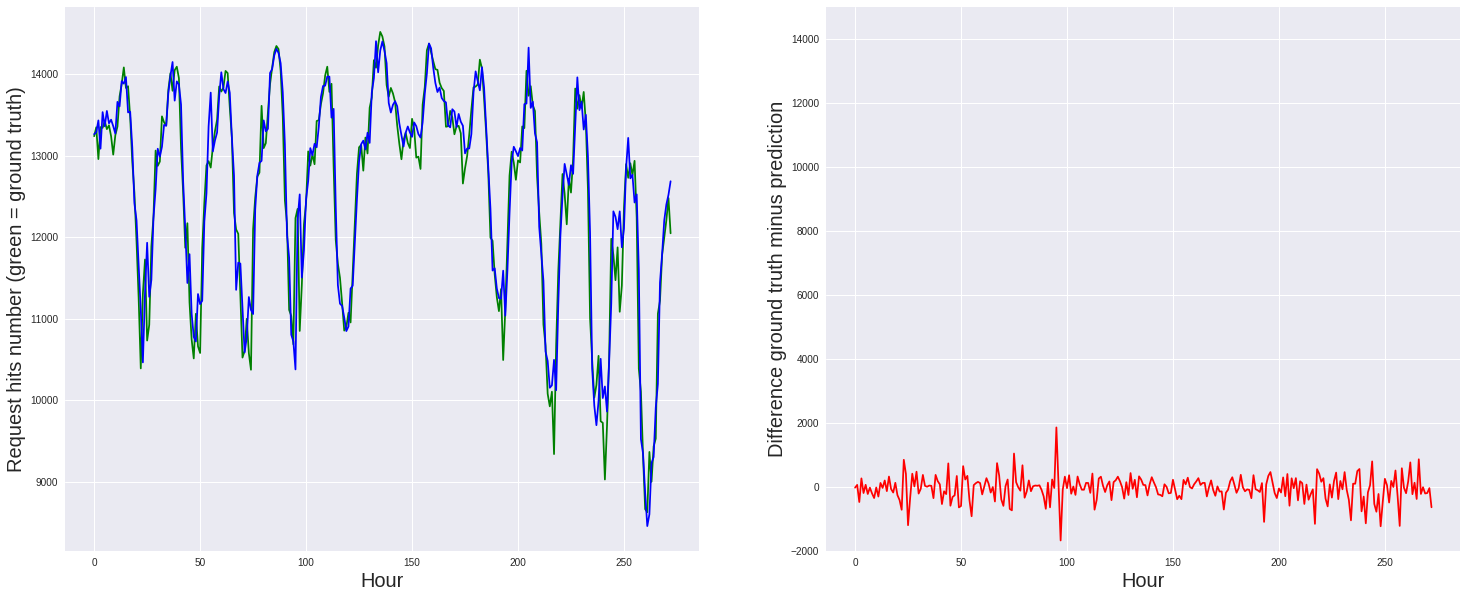

In [73]:
compare_plot(model, scale, X_test, y_test)